# 🧠 NeuroMentor: A GenAI-powered Mental Wellness Companion

**Welcome to NeuroMentor!**  
Your AI companion for emotional support, positive conversations, and mental wellness exploration.

**Built using:**
- **Google's Gemini 1.5 Pro**
- **Gemini Pro Vision**
- **Hugging Face Transformers**
- **LangChain**
- **Streamlit**

---

### Features:
- 🎤 **Voice-enabled**
- 📄 **Document-aware**
- 🧠 **Emotionally empathetic**

Let's transform the future of well-being with AI! 🚀

---

## 🎯 Problem Statement

Mental health is a growing concern—especially among students, job seekers, and tech professionals under pressure.  
There is a need for a private, supportive, and intelligent AI assistant that helps manage stress, track moods, and offer motivational support with personalized insights.

**NeuroMentor** builds a Generative AI-powered wellness companion using:
- LLMs
- Vector search
- GenAI agents
- Document understanding techniques

---

## 💎 What Makes NeuroMentor Unique?
- ✅ **Emotion-aware journaling**: Understands emotional context via personalized journaling prompts.
- ✅ **Personal doc insights**: Analyzes uploaded personal documents (journals, books, goals) for reflective insights.
- ✅ **Adaptive daily check-ins**: Offers adaptive daily check-ins using few-shot prompting and agents.
- ✅ **Private, personal & empowering**: Your data remains yours.

Built with real-world impact and cutting-edge GenAI technologies! 🚀

---

## 🔧 Core GenAI Features

| **Feature**                 | **GenAI Capability**                     |
|-----------------------------|------------------------------------------|
| 📝 **Emotion-aware journaling** | Prompt Engineering + JSON mode           |
| 📚 **Personal doc insights**    | Embeddings + Vector Search               |
| 🔁 **Adaptive daily check-ins** | Agents + Few-shot prompting              |
| 💡 **Motivational content**    | Retrieval Augmented Generation (RAG)     |
| 📈 **Mood trend insights**     | Structured Output + Visualizations       |

---

## 🚀 Let's Build NeuroMentor!

### Step-by-Step Guide:

1️⃣ **Install Libraries**  
   Make sure you have all the required libraries installed.

2️⃣ **Import Libraries**  
   Import the necessary libraries, including `google.generativeai`, `requests`, `streamlit`, `huggingface`, and others.

3️⃣ **Setup API Keys (Environment Variables)**  
   Store your API keys securely using environment variables or a secrets manager (e.g., Kaggle Secrets, .env files).

4️⃣ **Define Utility Functions (Chat Memory, Voice, Vision)**  
   Create functions for managing chat memory, processing voice inputs, and integrating vision capabilities (if applicable).

5️⃣ **Build Core NeuroMentor Agent (generate_response)**  
   Implement the logic for generating personalized responses based on user input. Include sentiment analysis, motivational content generation, and mood tracking.

6️⃣ **Build Core Pages:**
   - **ChatterBox**: The chat interface for real-time conversations.
   - **Voice Lounge**: A voice-enabled interaction page.
   - **Docs & Images**: Document upload and analysis for personalized insights.
   - **Web Search**: Perform web searches for relevant content.
   - **History & Insights**: Track mood trends, session history, and insights.

7️⃣ **Final Wrap-up & Execution**  
   Once everything is built and integrated, wrap up the project by testing, deploying to Streamlit, and ensuring a smooth user experience.

---

This project will combine cutting-edge GenAI technologies to support mental wellness, provide a personalized experience for users, and offer real-time support. The **NeuroMentor** is an intelligent, compassionate companion for anyone looking to improve their mental well-being.

---

Let's build this step-by-step inside this notebook 👇

In [115]:
# 📦 Install all necessary packages in Kaggle in ONE clean cell

!pip install --upgrade --quiet google-generativeai
!pip install --upgrade --quiet deepface
!apt-get update -qq
!apt-get install -y tesseract-ocr
!pip install --upgrade --quiet pytesseract
!pip install --upgrade --quiet pdfplumber
!pip install --upgrade --quiet Pillow

# Additional packages for Streamlit app, LangChain, Voice, etc.
!pip install --upgrade --quiet \
  streamlit \
  langchain langchain-google-genai \
  google-generativeai \
  transformers torch \
  sounddevice SpeechRecognition pyttsx3 \
  requests python-dotenv \
  scipy matplotlib pandas Pillow

# Specific version of fsspec
!pip install --upgrade --quiet fsspec==2024.10.0


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 202 not upgraded.


In [116]:
# Cell 2️⃣: Import All Libraries
# 📚 Import Libraries

# Basic Utilities
import os
import json
import time
import tempfile
import uuid
from datetime import datetime

# Web & App
import streamlit as st
import requests

# Data
import pandas as pd

# Audio Processing (NO sounddevice on Kaggle/Colab)
import scipy.io.wavfile as wav
import speech_recognition as sr
import pyttsx3

# Images
from PIL import Image

# GenAI and LLMs
from transformers import pipeline
from langchain_google_genai import ChatGoogleGenerativeAI
import google.generativeai as genai


In [117]:
# 📦 Cell 3: Load API Keys from Kaggle Secrets
from kaggle_secrets import UserSecretsClient
import os
import google.generativeai as genai

# Load secrets from Kaggle
secret_client = UserSecretsClient()
GOOGLE_API_KEY = secret_client.get_secret("GOOGLE_API_KEY")
SERPER_API_KEY = secret_client.get_secret("SERPER_API_KEY")

# Safety checks
if not GOOGLE_API_KEY or not SERPER_API_KEY :
    raise ValueError("❌ Missing GOOGLE_API_KEY, SERPER_API_KEY in Kaggle Secrets!")

# Set them as environment variables
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["SERPER_API_KEY"] = SERPER_API_KEY

# Confirm keys are loaded
print("✅ GOOGLE_API_KEY, SERPER_API_KEY, and REPLICATE_API_TOKEN loaded.")

# Configure Google Generative AI (Gemini Pro)
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
print("✅ Google Generative AI API is configured.")

# (Optional) List available models to verify key validity
# for m in genai.list_models():
#     print(m.name, m.supported_generation_methods)


✅ GOOGLE_API_KEY, SERPER_API_KEY, and REPLICATE_API_TOKEN loaded.
✅ Google Generative AI API is configured.


In [118]:
# Cell 4️⃣: Setup Gemini LLM and Helper Functions
import json
import requests

# — Gemini LLM via LangChain —
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    google_api_key=GOOGLE_API_KEY,
    temperature=0.6,
)

def get_gemini_response(prompt: str) -> str:
    try:
        r = llm.invoke(prompt)
        return getattr(r, "content", str(r))
    except Exception as e:
        return f"Error: {e}"

# — Web search via Serper.dev —
def live_search(query):
    """Perform web search using Serper.dev."""
    url = "https://google.serper.dev/search"
    headers = {
        "X-API-KEY": SERPER_API_KEY,
        "Content-Type": "application/json",
    }
    payload = json.dumps({"q": query})
    
    response = requests.post(url, headers=headers, data=payload)
    response.raise_for_status()
    
    search_results = response.json()
    return search_results.get("organic", [])

In [119]:
# 📄cell 5: NeuroMentor Home Page (Designed for Kaggle Notebook)

import streamlit as st

# Dummy replacement: define a function to simulate input/output inside a notebook
def notebook_homepage():
    # Title
    print("🧠 NeuroMentor: Your AI Wellness Companion\n")
    print("Welcome to a journey of self‑care and emotional wellness! 🌱\n")
    
    # Username input (simulate manually in notebook)
    username = input("👤 Enter your unique username: ").strip()

    if username:
        print(f"\n✅ Welcome, {username}!\n")
        print("👋 Logged in as", username)
        
        # Explore Sections
        print("\n### 🧭 Explore Sections")
        print("- 💬 ChatterBox")
        print("- 🎤 Voice Lounge")
        print("- 📄 Documents & Images")
        print("- 🌐 Search Solutions")
        print("- 📊 History & Insights")
    else:
        print("\n⚠️ Please enter a valid username to proceed.")
# Run
notebook_homepage()

🧠 NeuroMentor: Your AI Wellness Companion

Welcome to a journey of self‑care and emotional wellness! 🌱



👤 Enter your unique username:  ramya



✅ Welcome, ramya!

👋 Logged in as ramya

### 🧭 Explore Sections
- 💬 ChatterBox
- 🎤 Voice Lounge
- 📄 Documents & Images
- 🌐 Search Solutions
- 📊 History & Insights


In [121]:
# cell 6: 📲 ChatterBox - Chat with NeuroMentor

# Initialize conversation history
conversation_history = []

def chatterbox_interface():
    global conversation_history
    print("\n💬 ChatterBox: Chat with NeuroMentor\n")
    print("Type 'end' to exit the conversation.\n")
    
    # Start continuous chat loop
    while True:
        # Get user input for message
        user_input = input("You: ")

        # Check if the user wants to end the conversation
        if user_input.strip().lower() == 'end':
            print("\nEnding the conversation. Take care!")
            break  # Exit the loop
        
        if user_input.strip():  # Only proceed if input is not empty
            # Add user input to the conversation history
            conversation_history.append(f"You: {user_input}")
            
            # Combine all previous conversation history as context for the AI
            prompt = "\n".join(conversation_history)
            
            # Get response from Gemini
            response = get_gemini_response(prompt)
            
            # Add AI response to conversation history
            conversation_history.append(f"NeuroMentor: {response}")
            
            # Display the response from NeuroMentor
            print(f"\nNeuroMentor: {response}")
        else:
            print("\nPlease enter a message to continue the conversation.")

# Run the chat interface
chatterbox_interface()



💬 ChatterBox: Chat with NeuroMentor

Type 'end' to exit the conversation.



You:  iam very anger



NeuroMentor: It sounds like you're feeling very angry.  Do you want to talk about it?


You:  yes 



NeuroMentor: NeuroMentor: Okay, I'm here to listen.  What happened?  Take your time, and tell me what's making you feel this way.


You:  i fought with my sis



NeuroMentor: NeuroMentor: I understand.  Fighting with your sister can be really upsetting. Can you tell me more about what happened? What started the fight?


You:  end



Ending the conversation. Take care!


In [122]:
# cell 7: text_voice
# Install necessary libraries (run only once per session)
!pip install -q google-generativeai gtts

import google.generativeai as genai
from gtts import gTTS
from IPython.display import Audio, display

# Step 1: Set up Gemini

model = genai.GenerativeModel('gemini-1.5-pro')

# Step 2: Define functions
def get_ai_response(user_text):
    response = model.generate_content(user_text)
    return response.text

def text_to_speech(text, output_file="ai_response.mp3"):
    tts = gTTS(text=text, lang='en', slow=False)
    tts.save(output_file)
    return output_file

# Step 3: Start the conversation loop
print("\n💬 voice : conversation with NeuroMentor\n")
print("Start chatting with NeuroMentor! (Type 'end' to stop)\n")

while True:
    user_input = input("You: ")
    
    if user_input.strip().lower() == "end":
        print("\nConversation ended. Goodbye! 👋")
        break

    if user_input.strip() == "":
        print("Please enter a valid message!")
        continue

    # Get AI response
    ai_reply = get_ai_response(user_input)
    print("\nNeuroMentor (AI Reply):", ai_reply)

    # Convert AI response to speech and play
    audio_file = text_to_speech(ai_reply)
    display(Audio(audio_file))



💬 voice : conversation with NeuroMentor

Start chatting with NeuroMentor! (Type 'end' to stop)



You:  iamm very happy today



NeuroMentor (AI Reply): That's wonderful! I'm happy for you.  Is there anything you'd like to share about what's making you so happy?



You:  yes i cracked interview 



NeuroMentor (AI Reply): Congratulations on cracking the interview!  That's fantastic news!  What are you going to do to celebrate?



You:  end



Conversation ended. Goodbye! 👋



💬 Document & Image with NeuroMentor




📥 Please enter the file name (e.g., 'document.pdf' or 'image.png') or type 'stop' to exit:  NeuroMentor_Motivation_Manual.pdf



📄 Processing PDF: NeuroMentor_Motivation_Manual.pdf

✅ File content ready!
🔵 You can now ask questions based ONLY on this document or emotion analysis.
🔵 Type 'end' to upload another file, or 'stop' to exit the program.



You:  about what this files tell



🤖 NeuroMentor (AI Reply): This guide is designed to support you in unlocking your potential through daily practices focused on motivation and mindset.  It offers gentle reminders and tools for cultivating a positive mindset each morning, overcoming self-doubt, connecting with your purpose, building resilience during challenges, and using affirmations to strengthen your self-belief.  It's a compassionate companion to help you remember your inner strength and navigate life's ups and downs with greater clarity and peace.  It reminds you that you already have everything you need within you, and this guide is simply here to help you remember that truth.




You:  what are the supporting portentials are their



🤖 NeuroMentor (AI Reply): This guide focuses on unlocking your potential in these key areas:

* **Mindset:** Cultivating a positive and focused mindset, especially in the morning, to shape your day with intention and gratitude.  It offers tools to overcome self-doubt and negative thoughts.

* **Purpose:**  Connecting with your deeper purpose to fuel your motivation and guide your progress.  It encourages reflection on what truly excites you and what impact your growth has on others.

* **Resilience:**  Building emotional strength to navigate challenging times.  It provides tools like deep breathing and reframing difficult situations to help you bend, not break.

* **Self-Belief:**  Nurturing confidence and trust in yourself and your journey.  Daily affirmations are provided to reinforce your inherent worth and ability to grow.

You already possess these potentials within you. This guide is simply a gentle reminder and a map to help you access them.  You've got this.




You:  end



📂 Returning to file upload...

💬 Document & Image with NeuroMentor




📥 Please enter the file name (e.g., 'document.pdf' or 'image.png') or type 'stop' to exit:  pic.jpg



🖼️ Processing Image: pic.jpg


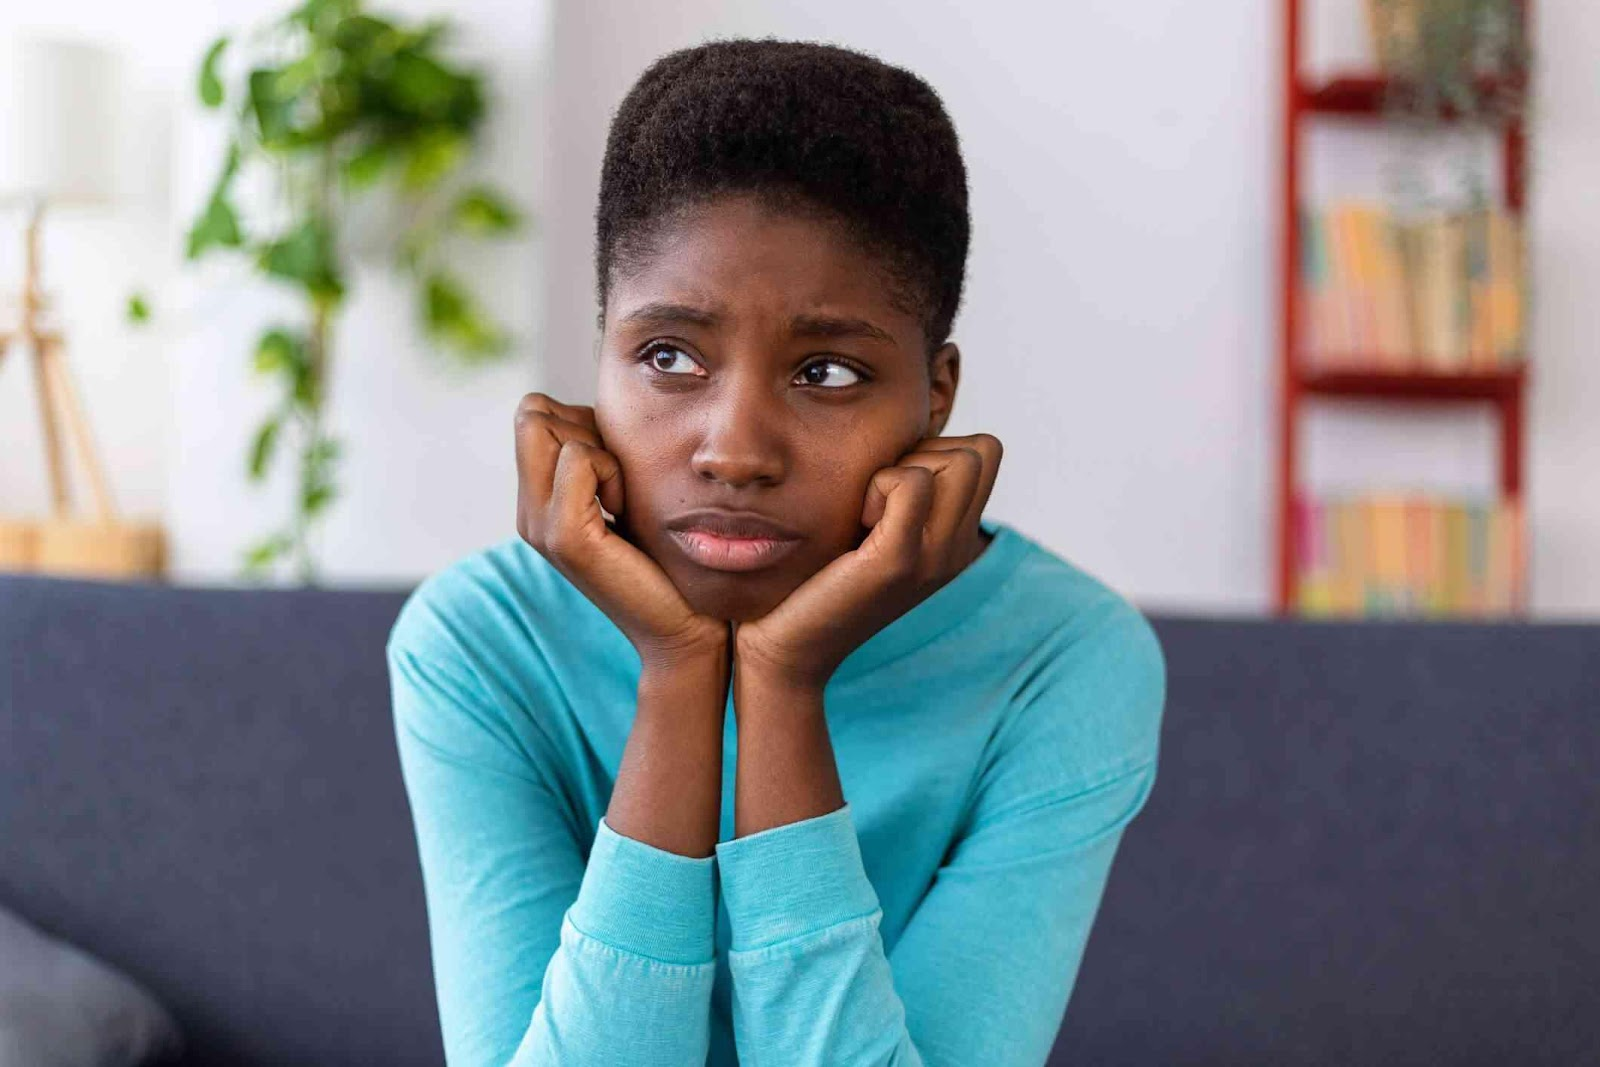


😊 Detected Emotion: Neutral
🌿 Healing Suggestion: You seem calm. Reflect on your thoughts or journal for deeper clarity. 📖

✅ File content ready!
🔵 You can now ask questions based ONLY on this document or emotion analysis.
🔵 Type 'end' to upload another file, or 'stop' to exit the program.



You:  what my face is expressing can u give me a brief discretion about



🤖 NeuroMentor (AI Reply): Your face appears to be expressing a neutral emotion, suggesting a sense of calmness.  This can be a good time for reflection or journaling to explore your thoughts and gain deeper self-awareness.




You:  end



📂 Returning to file upload...

💬 Document & Image with NeuroMentor




📥 Please enter the file name (e.g., 'document.pdf' or 'image.png') or type 'stop' to exit:  stop



👋 Exiting the program. Goodbye!


In [123]:
# cell 8: Document & Image with NeuroMentor
import os
import google.generativeai as genai
import pdfplumber
from PIL import Image
import pytesseract
from IPython.display import display
from deepface import DeepFace

# Step 0: Setup Gemini API
model = genai.GenerativeModel('gemini-1.5-pro')

# Healing suggestions based on emotion
healing_suggestions = {
    "happy": "You seem joyful! Celebrate your wins. Practice gratitude today. 🌟",
    "sad": "It’s okay to feel down. Try a short mindfulness session and write 3 things you're grateful for. 🧘‍♀️",
    "angry": "Take 5 deep breaths. Step away and allow yourself to cool down with calming music. 🎵",
    "fear": "You are safe. A grounding exercise or affirmations might help you feel secure. 🤲",
    "neutral": "You seem calm. Reflect on your thoughts or journal for deeper clarity. 📖",
    "disgust": "Try to focus on something positive or something you love. Reframe the situation if you can. 💖",
    "surprise": "Pause and embrace the unexpected. New experiences bring new growth! 🌱"
}

# Step 1: Main Loop
while True:
    print("\n💬 Document & Image with NeuroMentor\n")
    uploaded_filename = input("\n📥 Please enter the file name (e.g., 'document.pdf' or 'image.png') or type 'stop' to exit: ")

    if uploaded_filename.lower() in ['stop', 'exit', 'quit']:
        print("\n👋 Exiting the program. Goodbye!")
        break

    # Step 2: Set folder path based on extension
    if uploaded_filename.lower().endswith('.pdf'):
        uploaded_folder = "/kaggle/input/neuromentor-motivation-manual/"
    elif uploaded_filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        uploaded_folder = "/kaggle/input/sample-images/"
    else:
        print("⚠️ Unsupported file format. Please upload a PDF or an image file.")
        continue

    uploaded_path = os.path.join(uploaded_folder, uploaded_filename)

    file_content = ""  # Reset content for each file

    # Step 3: Process file
    if uploaded_filename.lower().endswith('.pdf'):
        print(f"\n📄 Processing PDF: {uploaded_filename}")
        with pdfplumber.open(uploaded_path) as pdf:
            for page in pdf.pages:
                text = page.extract_text()
                if text:
                    file_content += text

        if file_content.strip() == "":
            print("⚠️ No text found in the PDF.")
            continue

    elif uploaded_filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        print(f"\n🖼️ Processing Image: {uploaded_filename}")
        image = Image.open(uploaded_path)
        display(image)

        try:
            # Emotion detection using DeepFace
            analysis = DeepFace.analyze(img_path=uploaded_path, actions=['emotion'], enforce_detection=False)
            emotion = analysis[0]['dominant_emotion']
            suggestion = healing_suggestions.get(emotion.lower(), "Stay mindful and take care of yourself.")

            print(f"\n😊 Detected Emotion: {emotion.capitalize()}")
            print(f"🌿 Healing Suggestion: {suggestion}")

            # Set file content for chatting
            file_content = f"Detected dominant emotion: {emotion}. Suggested healing: {suggestion}"

        except Exception as e:
            print(f"❌ Could not analyze face emotions: {e}")
            continue

    # Step 4: Start conversation based on file
    print("\n✅ File content ready!")
    print("🔵 You can now ask questions based ONLY on this document or emotion analysis.")
    print("🔵 Type 'end' to upload another file, or 'stop' to exit the program.")

    while True:
        user_input = input("\nYou: ")
        if user_input.lower() in ['end']:
            print("\n📂 Returning to file upload...")
            break
        elif user_input.lower() in ['stop', 'exit', 'quit']:
            print("\n👋 Exiting the program. Goodbye!")
            exit()

        prompt = f"""
You are a caring, compassionate assistant. Answer ONLY based on the following file content:

File Content:
\"\"\"
{file_content}
\"\"\"

User's Question: {user_input}

Reply clearly, with supportive and healing language.
"""

        # Step 5: Get AI response
        response = model.generate_content(prompt)
        print("\n🤖 NeuroMentor (AI Reply):", response.text)


In [124]:
# Cell 9: Web Search - Powered by Serper.dev

import requests
import json

# Function to summarize the top links using Gemini
def summarize_links(links):
    """Send top links to Gemini to summarize for the user."""
    context = "Summarize the following pages into simple, clear, helpful tips for a student or professional:\n"
    for idx, link in enumerate(links, 1):
        context += f"{idx}. {link}\n"

    # Call Gemini to summarize
    summary = get_gemini_response(context)

    # Extract only the text part if summary is an object
    return summary.strip()

# Function to perform web search
def render_web_search():
    """Render the web search functionality."""
    print("🌐 NeuroMentor Web Search")
    print("Ask your questions, get smart, supportive answers!")

    query = input("What's your question? (Ask clearly): ")
    if not query.strip():
        print("❗ Please enter a valid question.")
        return

    print("Searching the web and preparing your personalized answer...")
    
    # Perform the web search using the live_search function
    results = live_search(query)

    if results:
        # Take the top 3 links
        top_links = [r.get("link") for r in results[:3] if r.get("link")]

        if top_links:
            # Summarize using Gemini
            summarized_answer = summarize_links(top_links)

            # Show summarized answer
            print("✅ NeuroMentor's Summarized Answer:")
            print(f"\n🧠 NeuroMentor says:\n\n{summarized_answer}\n")

            # Show helpful reference links
            print("\n---")
            print("🔗 Helpful References:")
            for link in top_links:
                print(f"- {link}")
        else:
            print("⚠️ No valid links found in the search results.")
    else:
        print("⚠️ No results found or an error occurred. Try rephrasing your question!")

# Call the render_web_search() function to start the search process
render_web_search()



🌐 NeuroMentor Web Search
Ask your questions, get smart, supportive answers!


What's your question? (Ask clearly):  give me the 5 tips to study 


Searching the web and preparing your personalized answer...
✅ NeuroMentor's Summarized Answer:

🧠 NeuroMentor says:

## Effective Study Tips for Students & Professionals:

**Planning & Environment:**

* **Schedule dedicated study time:** Treat studying like any other important appointment. Block out specific times in your calendar and stick to them.
* **Find your ideal study space:**  Experiment with different locations (library, cafe, home) to find what environment minimizes distractions and maximizes your focus.
* **Break down large tasks:** Divide big assignments into smaller, manageable chunks to avoid feeling overwhelmed.
* **Set realistic goals:** Don't try to cram everything in at once. Set achievable goals for each study session.

**Study Techniques:**

* **Active recall:** Test yourself regularly.  Instead of passively rereading, try to retrieve the information from memory. Use flashcards, practice questions, or teach the material to someone else.
* **Vary your study methods:*

In [125]:
# cell 10: History & Insights - Sentiment Analysis Mode
import google.generativeai as genai

# === Sentiment Analysis using Gemini ===
def analyze_sentiment_with_gemini(text: str) -> str:
    try:
        # Initialize the Gemini model
        model = genai.GenerativeModel("gemini-1.5-pro")
        prompt = f"Analyze the sentiment of the following text: {text}"

        # Correct method call
        response = model.generate_content(prompt)
        sentiment = response.text.strip()

        return sentiment
    except Exception as e:
        print(f"❌ Error in sentiment analysis: {e}")
        return "Sentiment analysis failed."

# === Main Program ===
def main():
    print("\n🎯 History & Insights - Sentiment Analysis Mode")
    print("Type 'stop' anytime to exit.\n")
    
    while True:
        sample_text = input("Enter text for sentiment analysis (or type 'stop' to exit): ").strip()
        if sample_text.lower() == "stop":
            print("👋 Exiting the program. Goodbye!")
            break
        if sample_text:
            sentiment_result = analyze_sentiment_with_gemini(sample_text)
            print(f"📈 Sentiment Analysis Result: {sentiment_result}\n")
        else:
            print("❌ Please enter valid text.\n")

if __name__ == "__main__":
    main()



🎯 History & Insights - Sentiment Analysis Mode
Type 'stop' anytime to exit.



Enter text for sentiment analysis (or type 'stop' to exit):  i really enjoyed the event. Everything was perfectly organized and it made me feel happy


📈 Sentiment Analysis Result: The sentiment expressed in the text is strongly positive.  The writer explicitly states enjoyment ("I really enjoyed") and happiness ("it made me feel happy").  The compliment about the organization ("Everything was perfectly organized") further contributes to the positive tone.



Enter text for sentiment analysis (or type 'stop' to exit):  stop


👋 Exiting the program. Goodbye!


# Conclusion

NeuroMentor is more than just a chatbot—it's a **personalized, empathetic, and private mental wellness companion** built using the latest advancements in Generative AI.

By combining:
- **Emotion-aware journaling** through prompt engineering,
- **Personal document insights** using vector search,
- **Adaptive daily check-ins** with GenAI agents,
- **Motivational support** via Retrieval Augmented Generation (RAG),
- **Mood trend analysis** through structured outputs,

NeuroMentor offers users a **safe space** to express, reflect, and grow emotionally.

In a world where mental well-being is increasingly critical, NeuroMentor serves as a powerful example of how AI can be **ethically leveraged** to create **positive, meaningful, and lasting impact**.

With continuous enhancements like voice support, vision analysis, and adaptive conversations, NeuroMentor sets the foundation for the future of **AI-driven emotional support systems**.

✨ **Let's continue to innovate, care, and build a future where technology uplifts humanity.**

For a visual demonstration of the project and its execution in VSCode, check out the YouTube video demo [Watch the NeuroMentor Demo](https://youtu.be/kuIdqiiyhxM). This video showcases the real-time execution and interaction with NeuroMentor, offering deeper insights into its functionalities.


